## Filter Out Suspicious Basins

In [1]:
import os
import pandas as pd
from tqdm import tqdm

# Path to folder with CSVs
data_dir = "data/csv_files"

# Parameters for detecting suspicious data
window_size = 14               # Rolling window length (days)
std_threshold = 1e-5           # If rolling std is below this threshold, call it "constant"

suspicious_files = []

# Loop over each CSV file in the directory
for filename in tqdm(os.listdir(data_dir)):
    # Only process .csv files
    if not filename.endswith(".csv"):
        continue
    
    csv_path = os.path.join(data_dir, filename)
    
    # Read the CSV into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Make sure the 'discharge' column exists
    if "discharge" not in df.columns:
        continue
    
    # Compute the rolling standard deviation of 'discharge'
    rolling_std = df["discharge"].rolling(window_size).std()
    
    # If any segment’s std is below our threshold, flag as suspicious
    if (rolling_std < std_threshold).any():
        # Strip off the .csv extension and store just the base filename
        base_name = os.path.splitext(filename)[0]
        suspicious_files.append(base_name)

# Write out the suspicious file names to a txt file
with open("suspicious_files.txt", "w") as f:
    for name in suspicious_files:
        f.write(name + "\n")

print("Check complete. Suspicious file names saved to 'suspicious_files.txt'.")


100%|██████████| 976/976 [00:19<00:00, 51.24it/s]

Check complete. Suspicious file names saved to 'suspicious_files.txt'.


### Filter Out separately for each time period

In [4]:
import os
import pandas as pd
from tqdm import tqdm

# Path to folder with CSVs
data_dir = "data/csv_files"

# Define date ranges
train_start_date = '1981-01-01'
train_end_date   = '2000-12-31'
val_start_date   = '2001-01-01'
val_end_date     = '2010-12-31'
test_start_date  = '2011-01-01'
test_end_date    = '2022-12-31'

# Parameters for detecting suspicious data
window_size = 14               # Rolling window length (days)
std_threshold = 1e-5           # If rolling std is below this threshold => suspicious

# Lists to store suspicious files
suspicious_train = []
suspicious_val   = []
suspicious_test  = []

# Loop over each CSV file in the directory
for filename in tqdm(os.listdir(data_dir)):
    # Only process .csv files
    if not filename.endswith(".csv"):
        continue
    
    csv_path = os.path.join(data_dir, filename)
    
    # Read the CSV into a DataFrame
    # Make sure the first column "date" gets parsed as datetime
    df = pd.read_csv(csv_path, parse_dates=["date"])
    
    # Check if the 'discharge' column exists
    if "discharge" not in df.columns:
        continue
    
    # -----------------------
    # Training period check
    # -----------------------
    # Subset DataFrame to train date range
    df_train = df[(df["date"] >= train_start_date) & (df["date"] <= train_end_date)].copy()
    if not df_train.empty:
        rolling_std_train = df_train["discharge"].rolling(window_size).std()
        if (rolling_std_train < std_threshold).any():
            base_name = os.path.splitext(filename)[0]
            suspicious_train.append(base_name)
    
    # -----------------------
    # Validation period check
    # -----------------------
    # Subset DataFrame to validation date range
    df_val = df[(df["date"] >= val_start_date) & (df["date"] <= val_end_date)].copy()
    if not df_val.empty:
        rolling_std_val = df_val["discharge"].rolling(window_size).std()
        if (rolling_std_val < std_threshold).any():
            base_name = os.path.splitext(filename)[0]
            suspicious_val.append(base_name)
    
    # -----------------------
    # Test period check
    # -----------------------
    # Subset DataFrame to test date range
    df_test = df[(df["date"] >= test_start_date) & (df["date"] <= test_end_date)].copy()
    if not df_test.empty:
        rolling_std_test = df_test["discharge"].rolling(window_size).std()
        if (rolling_std_test < std_threshold).any():
            base_name = os.path.splitext(filename)[0]
            suspicious_test.append(base_name)

# ---------------------------------------------------
# Write out suspicious file names to text files
# ---------------------------------------------------
with open("suspicious_files_train.txt", "w") as f:
    for name in suspicious_train:
        f.write(name + "\n")

with open("suspicious_files_val.txt", "w") as f:
    for name in suspicious_val:
        f.write(name + "\n")

with open("suspicious_files_test.txt", "w") as f:
    for name in suspicious_test:
        f.write(name + "\n")

print("Check complete. Suspicious file names saved in:")
print("  - suspicious_files_train.txt")
print("  - suspicious_files_val.txt")
print("  - suspicious_files_test.txt")


100%|██████████| 976/976 [00:18<00:00, 52.57it/s]

Check complete. Suspicious file names saved in:
  - suspicious_files_train.txt
  - suspicious_files_val.txt
  - suspicious_files_test.txt


In [5]:
import os

data_dir = "data/csv_files"

# Read suspicious file lists
with open("suspicious_files_train.txt", "r") as f:
    suspicious_train = set(line.strip() for line in f if line.strip())

with open("suspicious_files_val.txt", "r") as f:
    suspicious_val = set(line.strip() for line in f if line.strip())

with open("suspicious_files_test.txt", "r") as f:
    suspicious_test = set(line.strip() for line in f if line.strip())

# Prepare lists to store the final (non-suspicious) filenames
train_files = []
val_files = []
test_files = []

# Loop over all CSVs in data_dir
for filename in os.listdir(data_dir):
    if not filename.endswith(".csv"):
        continue
    base_name = os.path.splitext(filename)[0]
    
    # If it's not suspicious for the training set, add to train_files
    if base_name not in suspicious_train:
        train_files.append(base_name)

    # If it's not suspicious for the validation set, add to val_files
    if base_name not in suspicious_val:
        val_files.append(base_name)

    # If it's not suspicious for the test set, add to test_files
    if base_name not in suspicious_test:
        test_files.append(base_name)

# Write the final lists out to text files
with open("train.txt", "w") as f:
    for name in train_files:
        f.write(name + "\n")

with open("validate.txt", "w") as f:
    for name in val_files:
        f.write(name + "\n")

with open("test.txt", "w") as f:
    for name in test_files:
        f.write(name + "\n")

print("Non-suspicious filename lists saved to train.txt, validate.txt, and test.txt.")


Non-suspicious filename lists saved to train.txt, validate.txt, and test.txt.


### Confirm graphically

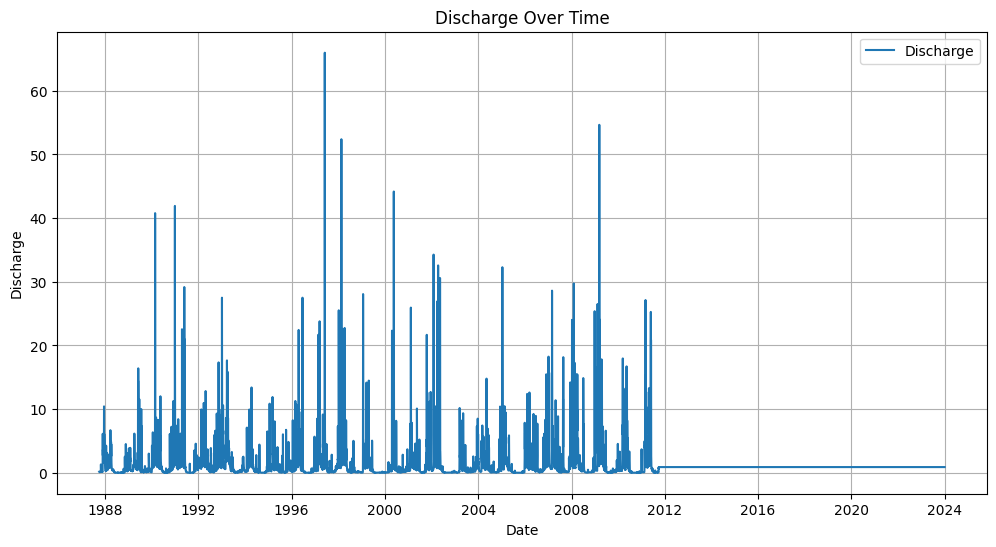

In [11]:
import matplotlib.pyplot as plt

def get_file_name(basin_id: str):
    file_name = str(basin_id) + ".csv"

    return "data/csv_files/" + file_name 

csv_path = get_file_name("04176605")

# Read the CSV file with "date" as an index
df = pd.read_csv(csv_path, index_col='date', parse_dates=True)

# Plot the "discharge" column
plt.figure(figsize=(12, 6))
plt.plot(df['discharge'], label='Discharge')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Discharge Over Time')
plt.legend()
plt.grid(True)
plt.show()